# Regularización en modelos de regresión lineal

En este notebook, exploramos algunas limitaciones de los modelos de regresión lineal y las ventajas de utilizar en su lugar modelos regularizados. Además la importancia de escalar los datos cuando se trabaja con modelos regularizados, especialmente al ajustar el parámetro de regularización.

Comenzamos destacando el problema del sobreajuste que puede producirse con un modelo de regresión lineal simple.


## Efecto de la regularización

Cargamos el conjunto de datos de viviendas de Ames. Retenemos algunas `características_de_interés`.

In [110]:
import pandas as pd

ames_housing = pd.read_csv("../data/ames_housing_no_missing.csv")
features_of_interest = [
    "LotFrontage",
    "LotArea",
    "PoolArea",
    "YearBuilt",
    "YrSold",
]
target_name = "SalePrice"
data, target = (
    ames_housing[features_of_interest],
    ames_housing[target_name],
)

In [111]:
ames_housing.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,Gd,MnPrv,Shed,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Grvl,Reg,Lvl,AllPub,FR2,...,0,Gd,MnPrv,Shed,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,Grvl,IR1,Lvl,AllPub,Inside,...,0,Gd,MnPrv,Shed,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,Grvl,IR1,Lvl,AllPub,Corner,...,0,Gd,MnPrv,Shed,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,Grvl,IR1,Lvl,AllPub,FR2,...,0,Gd,MnPrv,Shed,0,12,2008,WD,Normal,250000


Hemos visto que los modelos lineales podrían utilizarse incluso cuando no existe una relación lineal entre los `data` y `target`. Por ejemplo, se puede usar el transformador `PolynomialFeatures` para crear características adicionales que capturen algunas interacciones no lineales entre ellos.

Aquí, usamos este transformador para aumentar el espacio de características. Posteriormente, entrenamos un modelo de regresión lineal. Utilizamos validación cruzada con `return_train_score=True` para evaluar tanto los puntajes de entrenamiento como las capacidades de generalización de nuestro modelo.

para mas informacion consulte el siguiente link: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html


In [112]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

linear_regression = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False), LinearRegression()
).set_output(transform="pandas")
cv_results = cross_validate(
    linear_regression,
    data,
    target,
    cv=10,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    return_estimator=True,
)

In [113]:
cv_results = pd.DataFrame(cv_results)
cv_results.head(10)

,fit_time,score_time,estimator,test_score,train_score
0,0.006999,0.002999,"(PolynomialFeatures(include_bias=False), Linea...",-2.071576e+09,-2.976470e+09
1,0.005001,0.003000,"(PolynomialFeatures(include_bias=False), Linea...",-8.283226e+11,-2.773744e+09
2,0.006001,0.003000,"(PolynomialFeatures(include_bias=False), Linea...",-5.168548e+09,-2.938667e+09
3,0.005958,0.003001,"(PolynomialFeatures(include_bias=False), Linea...",-3.647309e+09,-2.810339e+09
4,0.004999,0.003000,"(PolynomialFeatures(include_bias=False), Linea...",-4.652973e+09,-2.695374e+09
5,0.004999,0.002000,"(PolynomialFeatures(include_bias=False), Linea...",-3.586131e+09,-2.875787e+09
6,0.006000,0.001999,"(PolynomialFeatures(include_bias=False), Linea...",-2.656640e+09,-2.923137e+09
7,0.005002,0.002995,"(PolynomialFeatures(include_bias=False), Linea...",-2.539446e+09,-2.926575e+09
8,0.004996,0.002001,"(PolynomialFeatures(include_bias=False), Linea...",-8.001450e+09,-2.794509e+09
9,0.004999,0.002000,"(PolynomialFeatures(include_bias=False), Linea...",-8.252142e+09,-2.783435e+09


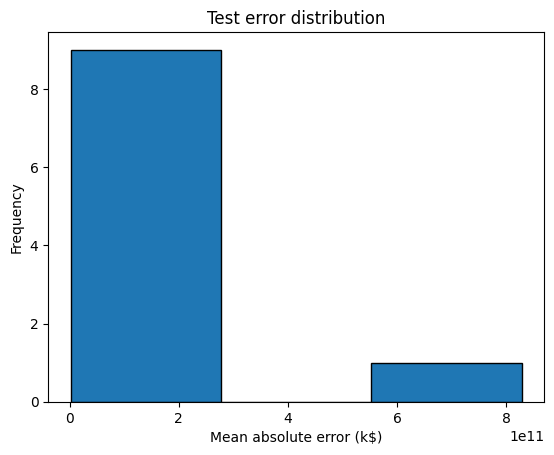

In [114]:
cv_results["test_error"] = -cv_results["test_score"]
cv_results["test_error"].plot.hist(bins=3, edgecolor="black")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Test error distribution")

Podemos comparar el error cuadrático medio en el conjunto de entrenamiento y en el conjunto de prueba para evaluar el rendimiento de generalización de nuestro modelo.

In [115]:
train_error = -cv_results["train_score"]
print(
    "Mean squared error of linear regression model on the train set:\n"
    f"{train_error.mean():.2e} ± {train_error.std():.2e}"
)

Mean squared error of linear regression model on the train set:
2.85e+09 ± 9.10e+07


In [116]:
test_error = -cv_results["test_score"]
print(
    "Mean squared error of linear regression model on the test set:\n"
    f"{test_error.mean():.2e} ± {test_error.std():.2e}"
)

Mean squared error of linear regression model on the test set:
8.69e+10 ± 2.61e+11


El error de entrenamiento es en promedio un orden de magnitud más bajo que el error de prueba (un error más bajo es mejor). Tal brecha entre los puntajes de entrenamiento y de prueba es una indicación de que nuestro modelo se sobreajustó al conjunto de entrenamiento. De hecho, este es uno de los peligros al aumentar el número de características con un transformador `PolynomialFeatures`. Por ejemplo, no se espera que características como `PoolArea * YrSold` sean muy predictivas.

Para analizar los pesos del modelo, podemos crear un dataframe. Las columnas del dataframe contienen los nombres de las características, mientras que las filas almacenan los coeficientes de cada modelo de un pliegue de validación cruzada dado.

Para obtener los nombres de las características asociados con cada combinación de características, necesitamos extraerlos de los datos aumentados creados por `PolynomialFeatures`. Afortunadamente, scikit-learn proporciona un método conveniente llamado `feature_names_in_` para este propósito. Comencemos por recuperar los coeficientes del modelo ajustado en el primer pliegue de validación cruzada.

In [117]:
model_first_fold = cv_results["estimator"][0]
model_first_fold

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('linearregression', LinearRegression())])

Ahora, podemos acceder al `LinearRegression` ajustado (paso `-1`, es decir, el último paso del pipeline `linear_regression`) para recuperar los nombres de las características.

In [118]:
feature_names = model_first_fold[-1].feature_names_in_
feature_names

array(['LotFrontage', 'LotArea', 'PoolArea', 'YearBuilt', 'YrSold',
       'LotFrontage^2', 'LotFrontage LotArea', 'LotFrontage PoolArea',
       'LotFrontage YearBuilt', 'LotFrontage YrSold', 'LotArea^2',
       'LotArea PoolArea', 'LotArea YearBuilt', 'LotArea YrSold',
       'PoolArea^2', 'PoolArea YearBuilt', 'PoolArea YrSold',
       'YearBuilt^2', 'YearBuilt YrSold', 'YrSold^2'], dtype=object)

El siguiente código crea una lista iterando a través de los estimadores y consultando su último paso para los `coef_` aprendidos. Luego podemos crear el dataframe que contiene toda la información.

In [119]:
import pandas as pd

coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_linear_regression = pd.DataFrame(coefs, columns=feature_names)
weights_linear_regression.head(10)

,LotFrontage,LotArea,PoolArea,YearBuilt,YrSold,LotFrontage^2,LotFrontage LotArea,LotFrontage PoolArea,LotFrontage YearBuilt,LotFrontage YrSold,LotArea^2,LotArea PoolArea,LotArea YearBuilt,LotArea YrSold,PoolArea^2,PoolArea YearBuilt,PoolArea YrSold,YearBuilt^2,YearBuilt YrSold,YrSold^2
0,77079.111213,-512.090773,295016.800527,-300425.727880,4.151276e+06,-3.349087,0.013700,7.350630,7.432073,-45.218037,-0.000025,-0.050043,0.022838,0.234804,1.229703,2.475124,-149.727504,23.836875,103.331738,-1084.219849
1,38950.535505,-651.513682,-443749.667769,-253011.958506,-1.649656e+05,-3.671420,0.023363,-57.044780,6.197283,-25.065176,-0.000029,0.086369,0.038975,0.288167,11.682741,279.035870,-55.356682,22.520468,82.266657,0.526541
2,107489.187827,46.540389,244398.334669,-284806.067061,2.427718e+06,-0.921627,-0.013052,7.320433,7.415126,-60.426930,-0.000030,-0.041796,0.020941,-0.040415,1.161346,3.439030,-125.490018,22.416630,98.327089,-651.731558
3,120924.363924,13.435421,300506.401703,-285833.879505,2.539970e+06,-3.816644,0.023443,7.532804,5.945237,-65.652102,-0.000029,-0.054480,0.033770,-0.037702,1.301935,2.362101,-152.353586,22.796892,98.096774,-679.564878
4,115490.944769,-439.225500,287588.265286,-326066.013846,1.592257e+06,-3.152245,0.012433,7.349500,7.977783,-64.916279,-0.000024,-0.048861,0.013451,0.207696,1.220988,2.902049,-146.449780,23.363805,117.031194,-453.182766
5,78028.211652,89.605237,581098.767531,-254831.243398,2.225779e+06,-3.891821,0.024950,9.799878,7.302737,-45.605856,-0.000027,-0.066454,0.016932,-0.059451,1.845552,6.149621,-296.023211,22.303180,83.651295,-594.464349
6,103438.169327,-293.678695,280123.084162,-244565.392482,3.459304e+06,-5.582935,0.018245,7.733341,7.421079,-58.219980,-0.000027,-0.048853,0.024097,0.124715,1.253121,2.661147,-142.521008,23.440090,76.275058,-898.316315
7,216852.442321,-495.049940,290727.579489,-258201.772774,3.487498e+06,-2.969074,0.014630,7.108650,7.161946,-114.593244,-0.000026,-0.050381,0.022024,0.227150,1.252334,2.724081,-147.831109,24.198309,81.598868,-907.138409
8,13661.821634,-497.760388,0.000095,-295928.763400,2.737438e+06,-2.767913,0.015438,-0.753053,6.668322,-12.988755,-0.000026,0.009408,0.027393,0.223211,-0.010382,0.216231,-0.217152,23.363781,102.024804,-732.141576
9,129362.627920,-603.474976,0.000278,-254300.214085,2.026232e+06,-3.036526,0.018756,15.648797,9.250921,-73.118128,-0.000029,-0.092233,0.017277,0.285845,0.196466,0.592758,-0.780995,24.040327,79.928429,-543.436299


Ahora, usemos un diagrama de caja para ver las variaciones en los coeficientes.

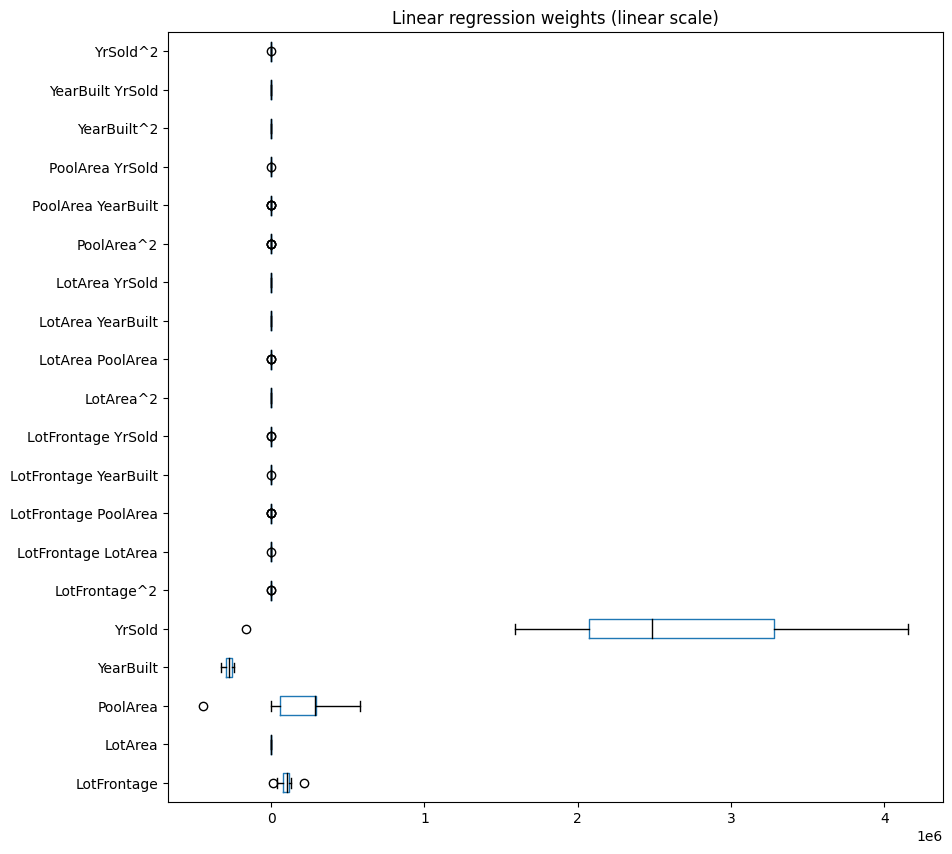

In [120]:
import matplotlib.pyplot as plt

color = {"whiskers": "black", "medians": "black", "caps": "black"}
fig, ax = plt.subplots(figsize=(10, 10))
weights_linear_regression.plot.box(color=color, vert=False, ax=ax)
_ = ax.set(title="Linear regression weights (linear scale)")

Al observar el gráfico de barras anterior, parecería que la mayoría de las características están muy cerca de cero, pero esto es solo un efecto de visualizarlas en la misma escala que el rango extremadamente grande de `"YrSold"`. En lugar de eso, podemos usar una escala logarítmica simétrica para el gráfico.

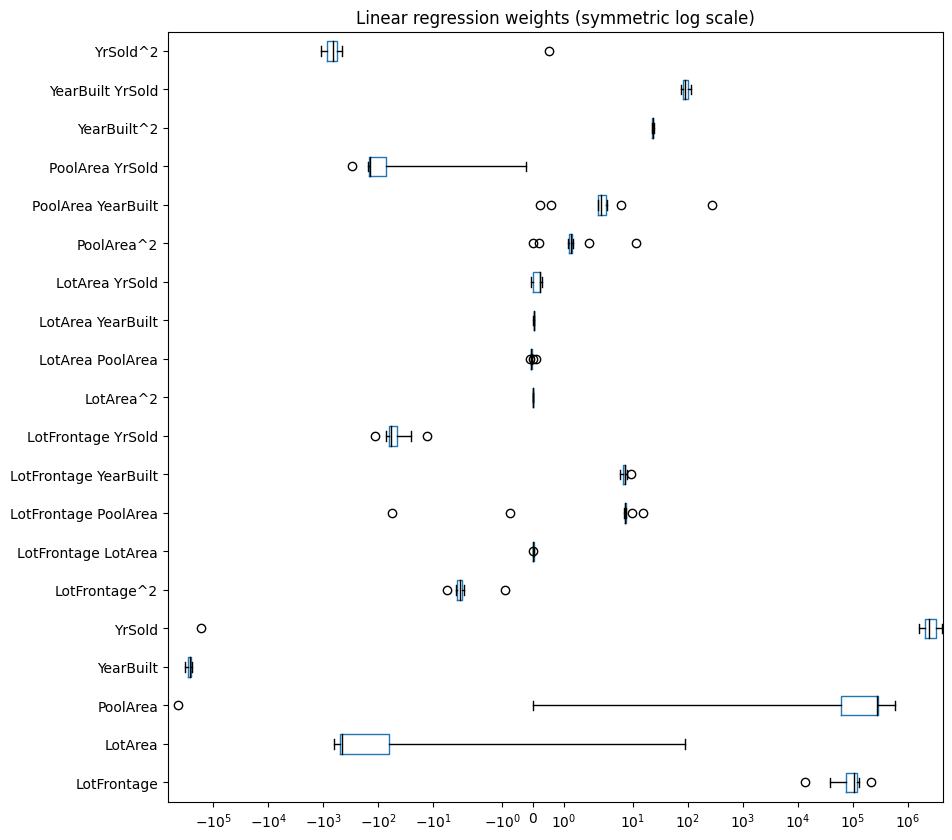

In [121]:
color = {"whiskers": "black", "medians": "black", "caps": "black"}
fig, ax = plt.subplots(figsize=(10, 10))
weights_linear_regression.plot.box(color=color, vert=False, ax=ax)
_ = ax.set(
    title="Linear regression weights (symmetric log scale)",
    xscale="symlog",
)

Observe que algunos coeficientes son extremadamente grandes mientras que otros son extremadamente pequeños, pero no son cero. Además, los valores de los coeficientes pueden ser muy inestables a lo largo de los pliegues de validación cruzada.

Podemos forzar al modelo de regresión lineal a considerar todas las características de una manera más homogénea. De hecho, podríamos forzar a que los pesos grandes positivos o negativos se reduzcan hacia cero. Esto se conoce como regularización. Utilizamos un modelo de regresión ridge que impone dicho comportamiento.

In [122]:
from sklearn.linear_model import Ridge

ridge = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    Ridge(alpha=100, solver="cholesky"),
)
cv_results = cross_validate(
    ridge,
    data,
    target,
    cv=20,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    return_estimator=True,
)

C:\Users\tabar\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.59923e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\tabar\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.59556e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\tabar\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.59609e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\tabar\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.11828e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\U

La celda de código anterior puede generar un par de advertencias (dependiendo de la elección del solucionador) porque las características incluyen tanto valores extremadamente grandes como extremadamente pequeños, lo que causa problemas numéricos al entrenar el modelo predictivo. Volveremos a eso en un momento.

Evaluemos los puntajes de entrenamiento y prueba de este modelo.

In [123]:
train_error = -cv_results["train_score"]
print(
    "Mean squared error of ridge model on the train set:\n"
    f"{train_error.mean():.2e} ± {train_error.std():.2e}"
)

Mean squared error of ridge model on the train set:
2.90e+09 ± 6.56e+07


In [124]:
test_error = -cv_results["test_score"]
print(
    "Mean squared error of ridge model on the test set:\n"
    f"{test_error.mean():.2e} ± {test_error.std():.2e}"
)

Mean squared error of ridge model on the test set:
4.55e+10 ± 1.68e+11


Vemos que los puntajes de entrenamiento y prueba se acercan, indicando que nuestro modelo tiene menos sobreajuste (¡aunque todavía está sobreajustado!). Podemos comparar los valores de los pesos de la regresión ridge con la regresión lineal sin regularizar.

In [125]:
coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_ridge = pd.DataFrame(coefs, columns=feature_names)

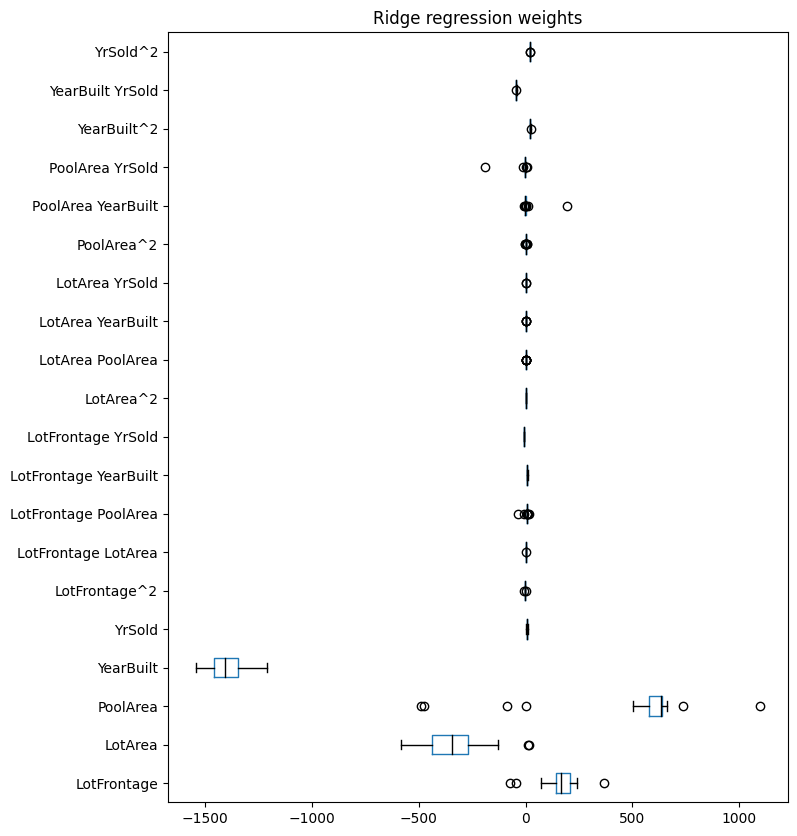

In [126]:
fig, ax = plt.subplots(figsize=(8, 10))
weights_ridge.plot.box(color=color, vert=False, ax=ax)
_ = ax.set(title="Ridge regression weights")

Observe que las magnitudes generales de los pesos se reducen (¡aunque no son cero!) con respecto al modelo de regresión lineal. Si lo desea, siéntase libre de usar una escala logarítmica simétrica en el gráfico anterior.

También puede observar que, aunque los valores de los pesos son menos extremos, todavía son inestables de un pliegue a otro. Incluso peor, los resultados pueden variar mucho dependiendo de la elección del solucionador (por ejemplo, intente establecer `solver="saga"` o `solver="lsqr"` en lugar de `solver="cholesky"` y vuelva a ejecutar las celdas anteriores).

En lo siguiente intentamos resolver esos problemas restantes, centrándonos en dos aspectos importantes que hemos omitido hasta ahora:
- la necesidad de **escalar los datos**, y
- la necesidad de **buscar el mejor parámetro de regularización**.



## Feature scaling y regularización


Por un lado, los pesos definen la asociación entre los valores de las características y el objetivo predicho, lo cual depende de las escalas tanto de los valores de las características como del objetivo. Por otro lado, la regularización añade restricciones a los pesos del modelo a través del parámetro `alpha`. Por lo tanto, el efecto que tiene el reescalado de características en los pesos finales también interactúa con el uso de la regularización.

Consideremos el caso en el que las características están en la misma escala/unidades: si el modelo encuentra que dos características son igualmente importantes, se ven afectadas de manera similar por la fuerza de la regularización.

Ahora, consideremos el escenario en el que dos características tienen escalas de datos completamente diferentes (por ejemplo, edad en años e ingresos anuales en dólares). Supongamos también que ambas características son aproximadamente igual de predictivas y no están demasiado correlacionadas. Ajustar una regresión lineal sin escalar y sin regularización daría un peso mayor a la característica con la escala natural más pequeña. Si añadimos regularización, la característica con la escala natural más pequeña sería penalizada más que la otra característica. Esto no es deseable dada la hipótesis de que ambas características son igualmente importantes. En tal caso, requerimos que la regularización se mantenga neutral.

En la práctica, no sabemos de antemano cuáles características son predictivas, y por lo tanto, queremos que la regularización trate a todas las características aproximadamente de igual manera por defecto. Esto se puede lograr reescalando las características.

Además, muchos solucionadores numéricos utilizados internamente en scikit-learn se comportan mejor cuando las características están aproximadamente en la misma escala. Los datos escalados de manera heterogénea pueden ser perjudiciales al resolver para encontrar los pesos óptimos (de ahí las advertencias que tendemos a recibir al ajustar modelos lineales en datos brutos). Por lo tanto, cuando se trabaja con un modelo lineal y datos numéricos, generalmente es una buena práctica escalar los datos.

Así, añadimos un `MinMaxScaler` en el pipeline de aprendizaje automático, que escala cada característica individualmente de tal manera que su rango se mapea en el rango entre cero y uno. Lo colocamos justo antes del transformador `PolynomialFeatures`, ya que las potencias de características en el rango entre cero y uno permanecen en el mismo rango.

In [127]:
from sklearn.preprocessing import MinMaxScaler

scaled_ridge = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=2, include_bias=False),
    Ridge(alpha=10, solver="cholesky"),
)
cv_results = cross_validate(
    scaled_ridge,
    data,
    target,
    cv=10,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    return_estimator=True,
)

In [128]:
train_error = -cv_results["train_score"]
print(
    "Mean squared error of scaled ridge model on the train set:\n"
    f"{train_error.mean():.2e} ± {train_error.std():.2e}"
)

Mean squared error of scaled ridge model on the train set:
3.78e+09 ± 1.21e+08


In [129]:
test_error = -cv_results["test_score"]
print(
    "Mean squared error of scaled ridge model on the test set:\n"
    f"{test_error.mean():.2e} ± {test_error.std():.2e}"
)

Mean squared error of scaled ridge model on the test set:
3.83e+09 ± 1.17e+09


Observamos que escalar los datos tiene un impacto positivo en el error de prueba: ahora es más bajo y está más cerca del error de entrenamiento. Esto significa que nuestro modelo tiene menos sobreajuste y que nos estamos acercando al mejor punto de generalización.

Si desea probar diferentes solucionadores, puede notar que ajustar este pipeline ya no genera ninguna advertencia, independientemente de dicha elección. Además, cambiar el solucionador ya no debería resultar en cambios significativos en los pesos.

Echemos un vistazo adicional a los diferentes pesos.

In [130]:
coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_ridge_scaled_data = pd.DataFrame(coefs, columns=feature_names)

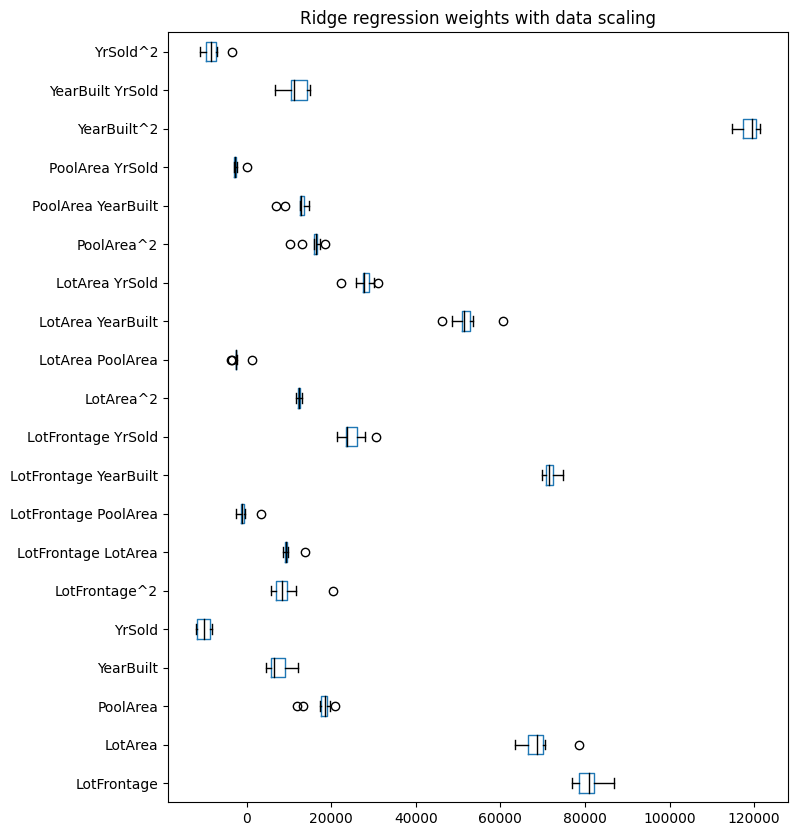

In [131]:
fig, ax = plt.subplots(figsize=(8, 10))
weights_ridge_scaled_data.plot.box(color=color, vert=False, ax=ax)
_ = ax.set(title="Ridge regression weights with data scaling")

En comparación con los gráficos anteriores, vemos que ahora la mayoría de las magnitudes de los pesos tienen un orden de magnitud similar, es decir, contribuyen de manera más equitativa. La cantidad de pesos inestables también disminuyó.

En el modelo anterior, establecimos `alpha=10`. Ahora podemos verificar el impacto de `alpha` aumentándolo a un valor muy grande.

In [132]:
ridge_large_alpha = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=2, include_bias=False),
    Ridge(alpha=1_000_000, solver="lsqr"),
)
cv_results = cross_validate(
    ridge_large_alpha,
    data,
    target,
    cv=10,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    return_estimator=True,
)

In [133]:
coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_ridge_scaled_data = pd.DataFrame(coefs, columns=feature_names)

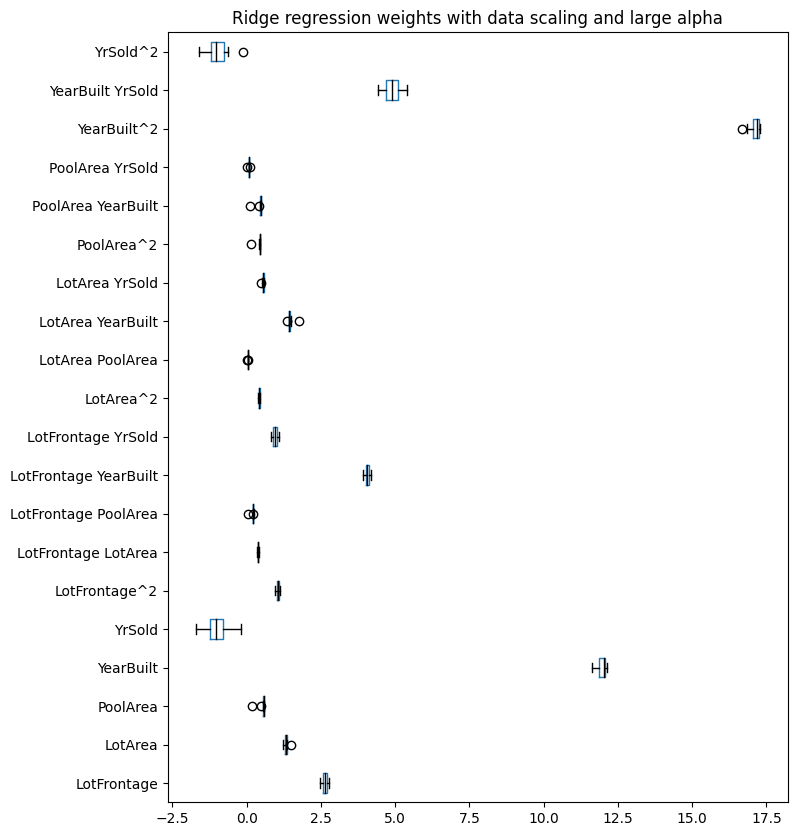

In [134]:
fig, ax = plt.subplots(figsize=(8, 10))
weights_ridge_scaled_data.plot.box(color=color, vert=False, ax=ax)
_ = ax.set(title="Ridge regression weights with data scaling and large alpha")

Al examinar los valores de los pesos, notamos que a medida que el valor de `alpha` aumenta, los pesos disminuyen. Un valor negativo de `alpha` puede llevar a un comportamiento impredecible e inestable en el modelo.

**Nota:**

Aquí, solo nos enfocamos en características numéricas. Para características categóricas, generalmente es común omitir el escalado cuando las características se codifican con un `OneHotEncoder`, ya que los valores de las características ya están en una escala similar.

Sin embargo, esta elección puede depender del método de escalado y del caso de uso. Por ejemplo, escalar características categóricas que están desequilibradas (por ejemplo, más ocurrencias de una categoría específica) igualaría el impacto de la regularización en cada categoría. Sin embargo, escalar tales características en presencia de categorías raras podría ser problemático (es decir, división por una desviación estándar muy pequeña) y, por lo tanto, podría introducir problemas numéricos.



En el análisis anterior, elegimos el parámetro de antemano y lo fijamos para el análisis. En la siguiente sección, verificamos cómo se debe ajustar el parámetro de regularización `alpha`.


## Ajuste del parámetro de regularización

Como se mencionó, el parámetro de regularización necesita ser ajustado en cada conjunto de datos. El parámetro por defecto no conduce al modelo óptimo. Por lo tanto, necesitamos ajustar el parámetro `alpha`.

El ajuste de hiperparámetros del modelo debe hacerse con cuidado. De hecho, queremos encontrar un parámetro óptimo que maximice algunas métricas. Por lo tanto, requiere tanto un conjunto de entrenamiento como un conjunto de prueba.

Sin embargo, este conjunto de prueba debería ser diferente del conjunto de prueba externo que usamos para evaluar nuestro modelo: si usamos el mismo, estamos usando un `alpha` que fue optimizado para este conjunto de prueba y se rompe la regla de muestra externa.

Por lo tanto, deberíamos incluir la búsqueda del hiperparámetro `alpha` dentro de la validación cruzada. Como vimos en cuadernos anteriores, podríamos usar una búsqueda en cuadrícula. Sin embargo, algunos predictores en scikit-learn están disponibles con una búsqueda de hiperparámetros integrada, más eficiente que usar una búsqueda en cuadrícula. El nombre de estos predictores termina en `CV`. En el caso de `Ridge`, scikit-learn proporciona un regresor `RidgeCV`.

La validación cruzada de un pipeline que contiene tales predictores permite hacer una validación cruzada anidada: la validación cruzada interna busca el mejor alpha, mientras que la validación cruzada externa da una estimación de la puntuación de prueba.
score.

In [135]:
import numpy as np
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-7, 5, num=100)
ridge = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=2, include_bias=False),
    RidgeCV(alphas=alphas, store_cv_values=True),
)

In [136]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=50, random_state=0)
cv_results = cross_validate(
    ridge,
    data,
    target,
    cv=cv,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    return_estimator=True,
    n_jobs=2,
)

In [137]:
train_error = -cv_results["train_score"]
print(
    "Mean squared error of tuned ridge model on the train set:\n"
    f"{train_error.mean():.2e} ± {train_error.std():.2e}"
)

Mean squared error of tuned ridge model on the train set:
3.12e+09 ± 1.25e+08


In [138]:
test_error = -cv_results["test_score"]
print(
    "Mean squared error of tuned ridge model on the test set:\n"
    f"{test_error.mean():.2e} ± {test_error.std():.2e}"
)

Mean squared error of tuned ridge model on the test set:
3.50e+09 ± 1.40e+09


Al optimizar `alpha`, observamos que las puntuaciones de entrenamiento y prueba están cerca. Esto indica que nuestro modelo no está sobreajustando.

Cuando ajustamos el regresor de cresta, también solicitamos almacenar el error encontrado durante la validación cruzada (estableciendo el parámetro `store_cv_values=True`). Podemos graficar el error cuadrático medio para las diferentes intensidades de regularización `alphas` que probamos. Las barras de error representan una desviación estándar del error cuadrático medio promedio a través de los pliegues para un valor dado de `alpha`.

In [139]:
mse_alphas = [
    est[-1].cv_values_.mean(axis=0) for est in cv_results["estimator"]
]
cv_alphas = pd.DataFrame(mse_alphas, columns=alphas)
cv_alphas = cv_alphas.aggregate(["mean", "std"]).T
cv_alphas

,mean,std
1.000000e-07,5.841881e+10,5.347783e+10
1.321941e-07,5.837563e+10,5.343115e+10
1.747528e-07,5.831866e+10,5.336956e+10
2.310130e-07,5.824352e+10,5.328835e+10
3.053856e-07,5.814452e+10,5.318133e+10
...,...,...
3.274549e+04,6.319038e+09,1.337394e+08
4.328761e+04,6.324503e+09,1.338181e+08
5.722368e+04,6.328652e+09,1.338778e+08
7.564633e+04,6.331799e+09,1.339232e+08


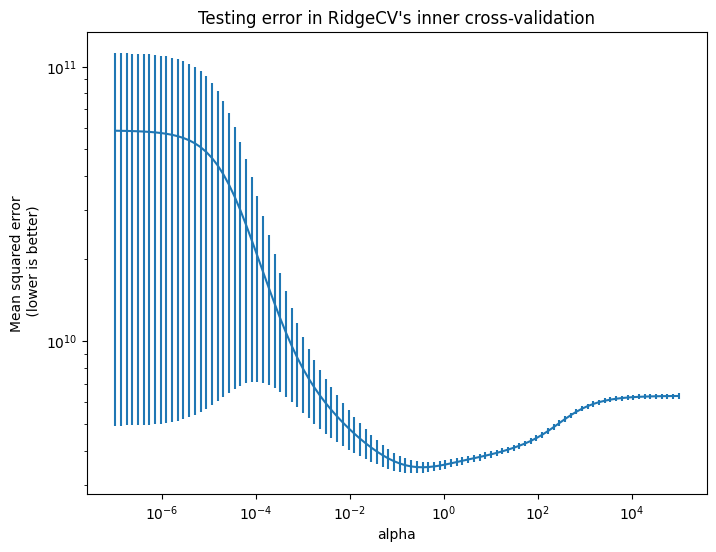

In [140]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(cv_alphas.index, cv_alphas["mean"], yerr=cv_alphas["std"])
_ = ax.set(
    xscale="log",
    xlabel="alpha",
    yscale="log",
    ylabel="Mean squared error\n (lower is better)",
    title="Testing error in RidgeCV's inner cross-validation",
)

Como podemos ver, la regularización es como la sal en la cocina: hay que equilibrar su cantidad para obtener el mejor rendimiento de generalización. Podemos verificar si el mejor `alpha` encontrado es estable a través de los pliegues de validación cruzada.

In [141]:
best_alphas = [est[-1].alpha_ for est in cv_results["estimator"]]
best_alphas

[0.11497569953977356,
 0.35111917342151344,
 0.1519911082952933,
 0.35111917342151344,
 0.11497569953977356,
 0.4641588833612782,
 0.4641588833612782,
 0.4641588833612782,
 0.4641588833612782,
 0.35111917342151344,
 0.35111917342151344,
 0.4641588833612782,
 0.11497569953977356,
 0.11497569953977356,
 0.35111917342151344,
 0.4641588833612782,
 0.11497569953977356,
 0.35111917342151344,
 0.35111917342151344,
 0.35111917342151344,
 0.35111917342151344,
 0.4641588833612782,
 0.35111917342151344,
 0.4641588833612782,
 0.35111917342151344,
 0.35111917342151344,
 0.35111917342151344,
 0.08697490026177834,
 0.6135907273413176,
 0.4641588833612782,
 0.35111917342151344,
 0.4641588833612782,
 0.4641588833612782,
 0.11497569953977356,
 0.35111917342151344,
 0.35111917342151344,
 0.4641588833612782,
 0.35111917342151344,
 0.11497569953977356,
 0.08697490026177834,
 0.4641588833612782,
 0.4641588833612782,
 0.35111917342151344,
 0.35111917342151344,
 0.4641588833612782,
 0.35111917342151344,
 0.35

La fuerza óptima de regularización no necesariamente es la misma en todas las iteraciones de validación cruzada. Pero dado que esperamos que cada remuestreo de validación cruzada provenga de la misma distribución de datos, es una práctica común elegir el mejor `alpha` para poner en producción como aquel que se encuentra en el rango definido por:

In [142]:
print(
    f"Min optimal alpha: {np.min(best_alphas):.2f} and "
    f"Max optimal alpha: {np.max(best_alphas):.2f}"
)

Min optimal alpha: 0.09 and Max optimal alpha: 0.61


Este rango puede reducirse dependiendo de la ingeniería de características y el preprocesamiento.

Aquí hay un resumen de los puntos importantes destacados en este cuaderno:
- Escalar las características hace que el efecto de la regularización sea más uniforme: todas las variables son regularizadas por una magnitud comparable, lo que no sería necesariamente el caso con las escalas naturales de las características.
- Escalar las características hace que los solucionadores numéricos sean más estables, lo que también ayuda a sintonizar el parámetro de regularización de manera más independiente del solucionador utilizado para ajustar el modelo lineal.
- Sintonizar el parámetro de regularización del estimador `Ridge` se puede hacer de manera muy eficiente utilizando la clase `RidgeCV`. Envolverlo en una llamada a `cross_validate` hace posible evaluar el verdadero poder de generalización de todo el pipeline, incluyendo la sintonización del parámetro de regularización como parte del proceso de aprendizaje: esto es un ejemplo de "validación cruzada anidada".
- Hacer esto hace posible comprobar que el valor óptimo de la fuerza de regularización `alpha` es robusto a un remuestreo del conjunto de datos. Si no fuera el caso, indicaría un problema con el conjunto de datos (por ejemplo, presencia de valores atípicos en las características o en el objetivo que influencian el proceso de aprendizaje de manera desproporcionada) o una mala elección de otros elementos del pipeline de ingeniería de características.